# Offline diagnostics for single output networks following Rasp et al. (2018) architecture

# Shapley Difference

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printe
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

In [3]:
module_path = os.path.abspath(os.path.join('..'))
# Relative imports
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from utils.setup import SetupDiagnostics
from neural_networks.load_models import load_models, get_save_plot_folder, load_single_model
from utils.pcmci_aggregation import get_matrix_idx, get_matrix_insets_idx, get_matrix_2d_idx
from neural_networks.model_diagnostics import ModelDiagnostics
from utils.variable import Variable_Lev_Metadata
from utils.constants import SPCAM_Vars
from utils.plotting import plot_matrix, plot_matrix_insets

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [5]:
from pathlib import Path
import pickle
import datetime
import time
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Load Shapley dictionaries

In [6]:
def get_setup(cfg_file):
    argv  = ["-c", cfg_file]
    return SetupDiagnostics(argv)

In [7]:
def parse_txt_to_dict(txt_file):
    line_dict = dict()
    with open(txt_file, 'r') as f:
        for line in f:
            value, key = line.split(":")
            line_dict[key.lstrip().rstrip("\n")] = value.lstrip().rstrip()
    return line_dict

In [8]:
def load_shap_dict(bdir):
    if "prediction_thresholds" in Path(bdir).name:
        shap_dir = Path(bdir, "plots_offline_evaluation", f"shap{val_train}", "range-all_samples-1000_all")
    else: 
        shap_dir = Path(bdir, "plots_offline_evaluation", "shap", "range-all_samples-1000_all")
    outputs_map = Path(bdir, "outputs_map.txt")
    
    outputs_varname2save = parse_txt_to_dict(outputs_map)
    outputs_save2varname = {value: key for key, value in outputs_varname2save.items()}
    
    shap_dict_per_var = {}
    for file in glob.glob(str(shap_dir) + "/*.p"):
        with open(file, "rb") as f:
            d = pickle.load(f)
        var_save_key = re.findall(r"[0-9]_[0-9]+",Path(file).name)[0]
        shap_dict_per_var[Variable_Lev_Metadata.parse_var_name(outputs_save2varname[var_save_key])] = d
    return shap_dict_per_var


## Calculate SHAP matrix

In [9]:
def generate_output_vars(setup):
    output_list = list()
    # Use setup.output_order here instead of setup.spcam_outputs to get the right order of variables
    for spcam_var in setup.spcam_outputs:
        if spcam_var.dimensions == 3:
            for level, _ in setup.children_idx_levs:
                # There's enough info to build a Variable_Lev_Metadata list
                # However, it could be better to do a bigger reorganization
                var_name = f"{spcam_var.name}-{round(level, 2)}"
                # For CausalSingleNN, there are no networks for variables phq-3.64 and phq-7.59
                if setup.nn_type == "CausalSingleNN" and (var_name == "phq-3.64" or var_name == "phq-7.59"):
                    continue
                output_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
        elif spcam_var.dimensions == 2:
            var_name = spcam_var.name
            output_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
    return output_list

In [10]:
def generate_input_vars(setup):
    inputs_list = list()
    for spcam_var in setup.spcam_inputs:
        if spcam_var.dimensions == 3:
            for level, _ in setup.parents_idx_levs:
                # There's enough info to build a Variable_Lev_Metadata list
                # However, it could be better to do a bigger reorganization
                var_name = f"{spcam_var.name}-{round(level, 2)}"
                inputs_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
        elif spcam_var.dimensions == 2:
            var_name = spcam_var.name
            inputs_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
    return sorted([p for p in inputs_list], key=lambda x: setup.input_order_list.index(x),)
    

In [11]:
def calculate_shap_matrix(setup, shap_dict_per_var, metric):
    output_vars = {i: var for i, var in enumerate(generate_output_vars(single_setup))}
    input_vars = generate_input_vars(setup)
    
    num_inputs = len(input_vars)
    
    input_inverse_idx = list(range(num_inputs-1, -1, -1))
    input_inverse_idx2var = {i: input_vars[num_inputs - 1 - i] for i in range(num_inputs)}
    
    
    metric_key = "shap_values_" + metric
    shap_matrix = np.ma.zeros([len(output_vars), len(input_vars)])
    
    for i, var in output_vars.items():
        if setup.nn_type == "CausalSingleNN" and (str(var) == "phq-3.64" or str(var) == "phq-7.59"):
            # No causal drivers were found for these variables
            continue
            
        var_inputs_idx = {input: idx for idx, input in enumerate(shap_dict_per_var[var]["inputs"])}
        for k in range(num_inputs):
            j = input_inverse_idx[k]
            # Check if this input is an input for the current variables
            try: 
                shap_matrix[i, k] = shap_dict_per_var[var][metric_key][var_inputs_idx[j]]
            except KeyError: 
                # This means the input was not part of the variables network inputs
                pass
            
    return shap_matrix, input_inverse_idx2var, output_vars


## Plot SHAP matrix

In [12]:
def plot_matrix_shap(clima_case, nn_case, metric, input_dict_inv_remap_var,  dict_outputs_idxs, 
                     shap_matrix, diff=False, save=False, savenm=False, cmap=False, 
                     extend=False, interpolation='none', insets=False, **kwargs):
    # diff doesn't do anything
    
    # Miscellaneous for plotting
    in_vars, in_box_idx, in_ticks, in_ticks_labs = get_matrix_insets_idx(input_dict_inv_remap_var, inverted=True)
    out_vars, out_box_idx, out_ticks, out_ticks_labs = get_matrix_insets_idx(dict_outputs_idxs, insets=insets)


    # Plotting
    if diff is False and 'abs' in metric and 'sign' not in metric:
        # norm = colors.LogNorm(vmin=0., vmax=shap_matrix.max())
        # norm = colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=shap_matrix.min(), vmax=shap_matrix.max(), base=10)
        # norm = colors.PowerNorm(gamma=0.2)
        norm = colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=0., vmax=shap_matrix.max(), base=10)
        if not cmap: cmap='Reds'
        if not extend: extend='max'
    
    else:
        maximum = max(abs(shap_matrix.max()), abs(shap_matrix.min()))
        # vmax=maximum; vmin=-1*maximum
        vmax=0.1
        vmin=-0.1
        norm = colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=vmin, vmax=vmax, base=10)
        # norm = colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=-1., vmax=1., base=10)
        if not cmap: cmap='RdBu_r'
        if not extend: extend='both'
        
    cbar_label='SHAP values'
    
    if insets:
        out_vars_2d, out_vars_2d_ticks = get_matrix_2d_idx(dict_outputs_idxs)
        fig, ax = plot_matrix_insets(None, shap_matrix, 
                                     in_vars, in_box_idx, in_ticks, in_ticks_labs,
                                     out_vars, out_box_idx,out_ticks, out_ticks_labs,
                                     out_vars_2d, out_vars_2d_ticks, 
                                     extend, cbar_label, 
                                     dict_outputs_idxs=dict_outputs_idxs,
                                     mask=False,num_parents=False, 
                                     # vmin=vmin,
                                     # vmax=vmax,
                                     cmap=cmap,
                                     # norm=colors.CenteredNorm(),
                                     # norm=colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=-1., vmax=1., base=10) 
                                     norm=norm,
                                     interpolation=interpolation, )
    else:
        fig, ax = plot_matrix(None, shap_matrix,
                              in_vars, in_box_idx, in_ticks, in_ticks_labs,
                              out_vars, out_box_idx, out_ticks,  out_ticks_labs,
                              extend, cbar_label, mask=False, num_parents=False,
                              # vmin=vmin,
                              # vmax=vmax,
                              cmap=cmap,
                              # norm=colors.CenteredNorm(),
                              # norm=colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=-1., vmax=1., base=10)
                              norm=norm,
                              interpolation=interpolation,)
    
    if save:
        Path(save).mkdir(parents=True, exist_ok=True)
        f_name = f'SHAP_values_{nn_case}_{clima_case}_{metric}.png' if not savenm else savenm
        fig.savefig(f"{save}/{f_name}",dpi=1000.,bbox_inches='tight')
        print(f"Saved Shapley matrix {save}/{f_name}")
    return fig, ax

## SHAP matrices

### Metric

In [13]:
metric = "abs_mean"
PROJECT_ROOT = Path.cwd().parent.resolve()

### SingelNN SHAP matrix

In [14]:
single_base_dir = os.path.join(PROJECT_ROOT, "output_castle", "eval_nando", "single_nn") 
single_cfg = os.path.join(single_base_dir, "cfg_single_nn_diagnostics.yml")
single_setup = get_setup(single_cfg)

single_shap_dict_per_var = load_shap_dict(single_base_dir)

assert (len(single_shap_dict_per_var.keys()) == 65)

In [15]:
single_shap_matrix_abs_mean, single_input_inverse_idx2var, single_output_vars = \
    calculate_shap_matrix(single_setup, single_shap_dict_per_var, metric)

assert (single_shap_matrix_abs_mean.shape == (65, 94))

### CausalNN SHAP matrix

In [18]:
causal_base_dir = os.path.join(PROJECT_ROOT, "output_castle", "eval_nando", "causal_single_nn", 
                              "models_arch-rasp_thrs-opt-mse6") 
# causal_base_dir = os.path.join(PROJECT_ROOT, "output_castle", "eval_nando", "causal_single_nn", 
#                               "models_arch-rasp_thrs-opt-mse6_extra_2") 
# causal_base_dir = os.path.join(PROJECT_ROOT, "output_castle", "eval_nando", "causal_single_nn", 
#                               "models_arch-rasp_thrs-opt-r2max") 

causal_cfg = os.path.join(causal_base_dir, "cfg_causal_single_nn_diagnostics.yml")
causal_setup = get_setup(causal_cfg)

causal_shap_dict_per_var = load_shap_dict(causal_base_dir)

assert (len(causal_shap_dict_per_var.keys()) == 63)

In [19]:
causal_shap_matrix_abs_mean, causal_input_inverse_idx2var, causal_output_vars = \
    calculate_shap_matrix(causal_setup, causal_shap_dict_per_var, metric)

assert (causal_shap_matrix_abs_mean.shape == (65, 94))

### PreMaskNet SHAP matrix

In [20]:
pre_mask_net_base_dir = os.path.join(PROJECT_ROOT, "output_castle", "training_74_pre_mask_net_spars0.001") 
pre_mask_net_cfg = os.path.join(pre_mask_net_base_dir, "cfg_pre_mask_net.yml")
pre_mask_net_setup = get_setup(pre_mask_net_cfg)

pre_mask_net_shap_dict_per_var = load_shap_dict(pre_mask_net_base_dir)

assert (len(pre_mask_net_shap_dict_per_var.keys()) == 65)


Set leaky relu alpha to 0.3



In [21]:
pre_mask_net_shap_matrix_abs_mean, pre_mask_net_input_inverse_idx2var, pre_mask_net_output_vars = \
    calculate_shap_matrix(pre_mask_net_setup, pre_mask_net_shap_dict_per_var, metric)

assert (pre_mask_net_shap_matrix_abs_mean.shape == (65, 94))

### MaskNet SHAP matrix

In [35]:
# mask_net_base_dir = os.path.join(PROJECT_ROOT, "output_castle", "training_75_mask_net_bespoke_thresholds")
mask_net_base_dir = os.path.join(PROJECT_ROOT, "output_castle", "training_76_mask_net_prediction_thresholds") 
val_train = "_train"

if "prediction_thresholds" in Path(mask_net_base_dir).name:   
    mask_net_cfg = os.path.join(mask_net_base_dir, f"cfg_mask_net_thresholds{val_train}.yml")
else: 
    mask_net_cfg = os.path.join(mask_net_base_dir, "cfg_mask_net.yml")

mask_net_setup = get_setup(mask_net_cfg)

mask_net_shap_dict_per_var = load_shap_dict(mask_net_base_dir)

assert (len(mask_net_shap_dict_per_var.keys()) == 65)


Set leaky relu alpha to 0.3



In [36]:
mask_net_shap_matrix_abs_mean, mask_net_input_inverse_idx2var, mask_net_output_vars = \
    calculate_shap_matrix(mask_net_setup, mask_net_shap_dict_per_var, metric)

assert (mask_net_shap_matrix_abs_mean.shape == (65, 94))

## Differences

### SingleNN - MaskNet

In [37]:
if "prediction_thresholds" in Path(mask_net_base_dir).name:
    mask_net_base_shap_dir = Path(mask_net_base_dir, "plots_offline_evaluation", f"shap{val_train}", "range-all_samples-1000_all")
else: 
    mask_net_base_shap_dir = Path(mask_net_base_dir, "plots_offline_evaluation", "shap", "range-all_samples-1000_all")
output_dir = os.path.join(mask_net_base_shap_dir, "single_diff")

print(output_dir)

/p/project/icon-a-ml/kuehbacher1/projects/iglesias-suarez2yxx_spuriouslinks/output_castle/training_76_mask_net_prediction_thresholds/plots_offline_evaluation/shap_train/range-all_samples-1000_all/single_diff


In [38]:
shap_diff = single_shap_matrix_abs_mean - mask_net_shap_matrix_abs_mean

Saved Shapley matrix /p/project/icon-a-ml/kuehbacher1/projects/iglesias-suarez2yxx_spuriouslinks/output_castle/training_76_mask_net_prediction_thresholds/plots_offline_evaluation/shap_train/range-all_samples-1000_all/single_diff/SHAP_values_singleNN-MaskNet_0K_diff.png


FigureCanvasAgg is non-interactive, and thus cannot be shown


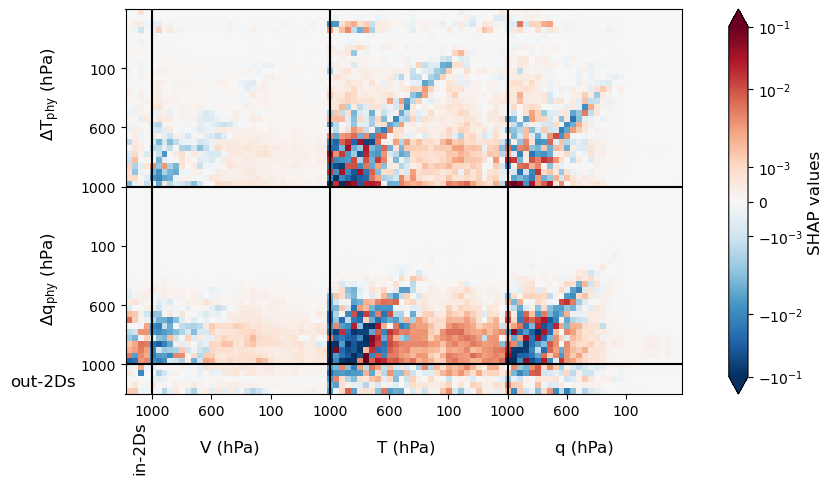

In [39]:
fig, ax = plot_matrix_shap("0K", "singleNN-MaskNet", "diff", mask_net_input_inverse_idx2var, 
                           mask_net_output_vars, shap_diff, save=output_dir)
fig.show()

### SingleNN - CausalSingleNN

In [32]:
# single_base_shap_dir = Path(single_base_dir, "plots_offline_evaluation", "shap", "range-all_samples-1000_all")
# output_dir = os.path.join(single_base_shap_dir, "causal_diff")
# print(output_dir)

causal_base_shap_dir = Path(causal_base_dir, "plots_offline_evaluation", "shap", "range-all_samples-1000_all")
output_dir = os.path.join(causal_base_shap_dir, "single_diff")
print(output_dir)

/p/project/icon-a-ml/kuehbacher1/projects/iglesias-suarez2yxx_spuriouslinks/output_castle/eval_nando/causal_single_nn/models_arch-rasp_thrs-opt-r2max/plots_offline_evaluation/shap/range-all_samples-1000_all/single_diff


In [33]:
shap_diff = single_shap_matrix_abs_mean - causal_shap_matrix_abs_mean

Saved Shapley matrix /p/project/icon-a-ml/kuehbacher1/projects/iglesias-suarez2yxx_spuriouslinks/output_castle/eval_nando/causal_single_nn/models_arch-rasp_thrs-opt-r2max/plots_offline_evaluation/shap/range-all_samples-1000_all/single_diff/SHAP_values_singleNN-causalNN_0K_diff.png


FigureCanvasAgg is non-interactive, and thus cannot be shown


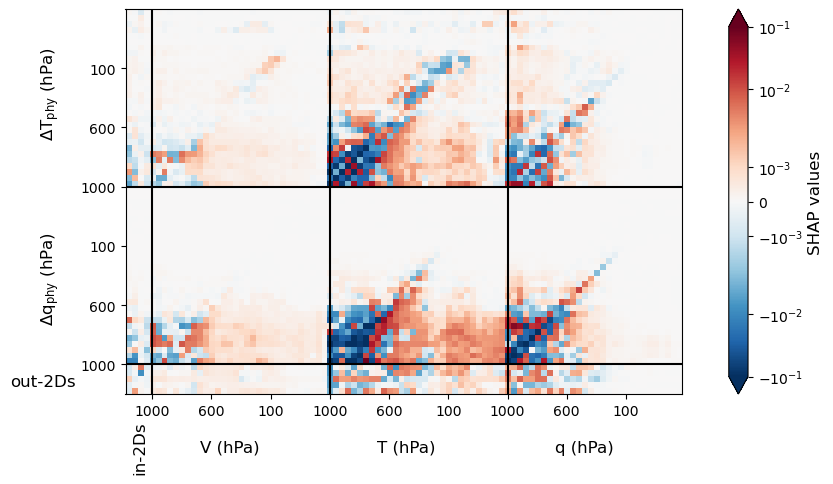

In [34]:
fig, ax = plot_matrix_shap("0K", "singleNN-causalNN", "diff", single_input_inverse_idx2var, single_output_vars, shap_diff, save=output_dir)
fig.show()

### PreMaskNet - MaskNet

In [40]:
if "prediction_thresholds" in Path(mask_net_base_dir).name:
    mask_net_base_shap_dir = Path(mask_net_base_dir, "plots_offline_evaluation", f"shap{val_train}", "range-all_samples-1000_all")
else: 
    mask_net_base_shap_dir = Path(mask_net_base_dir, "plots_offline_evaluation", "shap", "range-all_samples-1000_all")
output_dir = os.path.join(mask_net_base_shap_dir, "pre_mask_net_diff")
print(output_dir)

/p/project/icon-a-ml/kuehbacher1/projects/iglesias-suarez2yxx_spuriouslinks/output_castle/training_76_mask_net_prediction_thresholds/plots_offline_evaluation/shap_train/range-all_samples-1000_all/pre_mask_net_diff


In [41]:
shap_diff = pre_mask_net_shap_matrix_abs_mean - mask_net_shap_matrix_abs_mean

Saved Shapley matrix /p/project/icon-a-ml/kuehbacher1/projects/iglesias-suarez2yxx_spuriouslinks/output_castle/training_76_mask_net_prediction_thresholds/plots_offline_evaluation/shap_train/range-all_samples-1000_all/pre_mask_net_diff/SHAP_values_PreMaskNet-MaskNet_0K_diff.png


FigureCanvasAgg is non-interactive, and thus cannot be shown


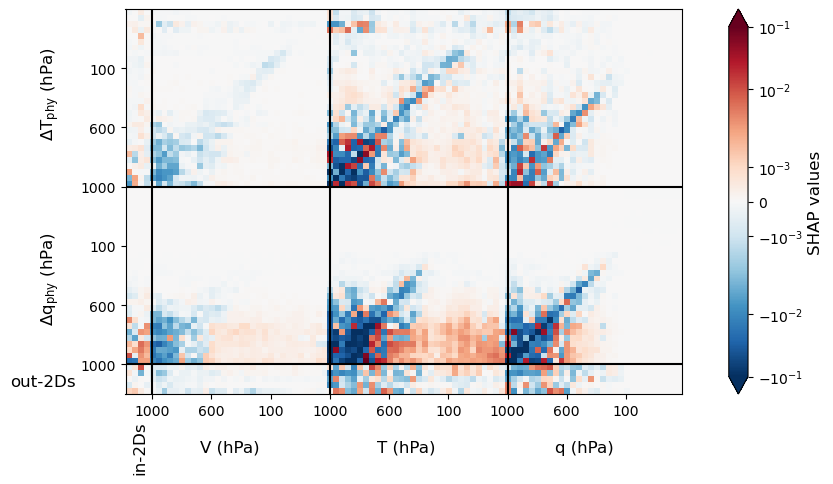

In [42]:
fig, ax = plot_matrix_shap("0K", "PreMaskNet-MaskNet", "diff", mask_net_input_inverse_idx2var, 
                           mask_net_output_vars, shap_diff, save=output_dir)
fig.show()

### SingleNN - PreMaskNet

In [53]:
pre_mask_net_base_shap_dir = Path(pre_mask_net_base_dir, "plots_offline_evaluation", "shap", "range-all_samples-1000_all")
output_dir = os.path.join(pre_mask_net_base_shap_dir, "single_diff")
print(output_dir)

/p/project/icon-a-ml/kuehbacher1/projects/iglesias-suarez2yxx_spuriouslinks/output_castle/training_74_pre_mask_net_spars0.001/plots_offline_evaluation/shap/range-all_samples-1000_all/single_diff


In [54]:
shap_diff = pre_mask_net_shap_matrix_abs_mean - single_shap_matrix_abs_mean

Saved Shapley matrix /p/project/icon-a-ml/kuehbacher1/projects/iglesias-suarez2yxx_spuriouslinks/output_castle/training_74_pre_mask_net_spars0.001/plots_offline_evaluation/shap/range-all_samples-1000_all/single_diff/SHAP_values_PreMaskNet-singleNN_0K_diff.png


FigureCanvasAgg is non-interactive, and thus cannot be shown


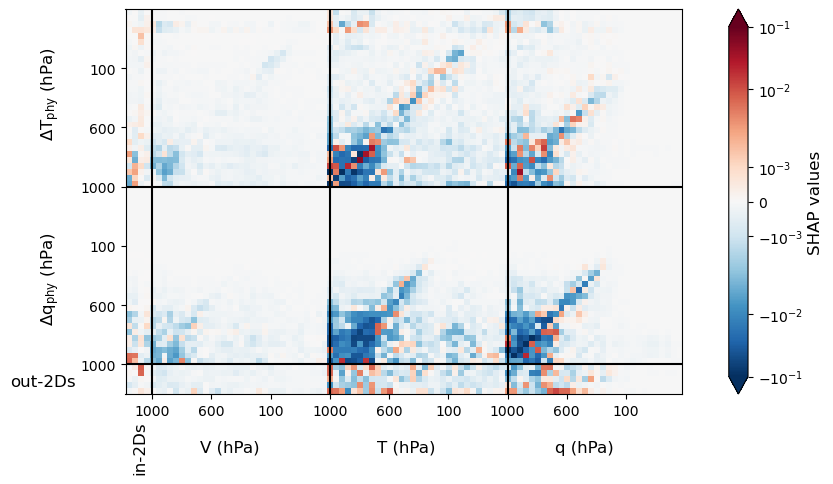

In [55]:
fig, ax = plot_matrix_shap("0K", "PreMaskNet-singleNN", "diff", pre_mask_net_input_inverse_idx2var, 
                           pre_mask_net_output_vars, shap_diff, save=output_dir)
fig.show()

### MaskNet - CausalSingleNN

In [43]:
if "prediction_thresholds" in Path(mask_net_base_dir).name:
    mask_net_base_shap_dir = Path(mask_net_base_dir, "plots_offline_evaluation", f"shap{val_train}", "range-all_samples-1000_all")
else: 
    mask_net_base_shap_dir = Path(mask_net_base_dir, "plots_offline_evaluation", "shap", "range-all_samples-1000_all")
output_dir = os.path.join(mask_net_base_shap_dir, "causal_diff")
print(output_dir)

# causal_base_shap_dir = Path(causal_base_dir, "plots_offline_evaluation", "shap", "range-all_samples-1000_all")
# output_dir = os.path.join(causal_base_shap_dir, "mask_net_diff")
# print(output_dir)

/p/project/icon-a-ml/kuehbacher1/projects/iglesias-suarez2yxx_spuriouslinks/output_castle/training_76_mask_net_prediction_thresholds/plots_offline_evaluation/shap_train/range-all_samples-1000_all/causal_diff


In [44]:
shap_diff = mask_net_shap_matrix_abs_mean - causal_shap_matrix_abs_mean

Saved Shapley matrix /p/project/icon-a-ml/kuehbacher1/projects/iglesias-suarez2yxx_spuriouslinks/output_castle/training_76_mask_net_prediction_thresholds/plots_offline_evaluation/shap_train/range-all_samples-1000_all/causal_diff/SHAP_values_MaskNet-causalNN_0K_diff.png


FigureCanvasAgg is non-interactive, and thus cannot be shown


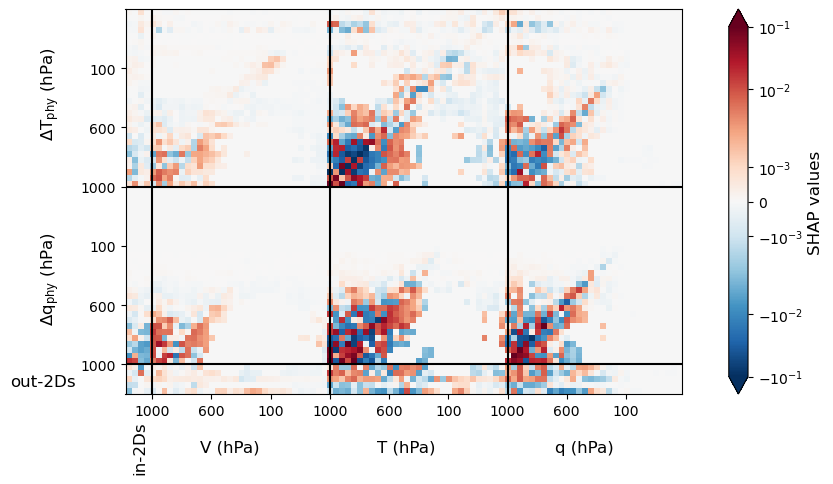

In [45]:
fig, ax = plot_matrix_shap("0K", "MaskNet-causalNN", "diff", mask_net_input_inverse_idx2var, 
                           mask_net_output_vars, shap_diff, save=output_dir)
fig.show()